In [ ]:
import os
import re
from enum import Enum
##
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import MultinomialNB
##
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
model_train_file_path = "https://drive.google.com/uc?id=1h2ti-z-trZOHfZiUJTCSbTW5CeowZVxz&export=download"
events_file_path = "https://drive.google.com/uc?id=1NFN0XGFLixnkIgL5TU7joEIi9WbOsGZE&export=download" #sample file
colab_events = pd.read_csv(events_file_path)
colab_events = colab_events[['user_id', 'description']]
colab_events.head(1)

,user_id,description
0,219046.0,Conforme relatado anteriormente no protocolo d...


In [ ]:
training_file_path = "https://drive.google.com/uc?id=1AXsY1tv7wGTf7w9-QT7LjJuP6qwcWjMy&export=download" #sample file
df_train = pd.read_csv(training_file_path)
df_train.head()

,post,label
0,Bom dia! Solicito a limpeza da rua João Pessoa...,helper
1,Peço a instalação de lixeiras na praça central...,helper
2,Preciso de informações sobre a coleta seletiva...,helper
3,Bom dia! Gostaria de saber o horário de funcio...,helper
4,Solicito a poda das árvores na avenida princip...,helper


In [ ]:
#
def process_row(row, classifier):
    colab_user_id = row[0]
    description = row[1]
    prediction = classifier.model.predict(description)
    score = prediction['score']

    if colab_user_id not in classifier.user_scores:
        classifier.user_scores[colab_user_id] = []

    classifier.user_scores[colab_user_id].append(score)
#
class ModelType(Enum):
  RANDOM_FOREST = 'RandomForest'
  LOGISTIC_REGRESSION = 'LogisticRegression'
  DECISION_TREE = 'DecisionTree'
  KNN = 'KNN'
#
#
class SentimentClassifierModel:
    def __init__(self, train_file_url):
        self.train_file_url = train_file_url
        self.data = None
        self.cv = CountVectorizer()
        self.trained_models = {}
        self.current_model = None
    #
    def load_data(self):
        self.data = pd.read_csv(self.train_file_url, low_memory=False)
    #
    @staticmethod
    def sanitize_phrase(phrase):
        stopwords_set = set(stopwords.words('portuguese'))
        result = ""
        for word in phrase.split(" "):
            review = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', word)
            review = review.lower()
            review = review.split()
            ps = PorterStemmer()
            # Stemming
            review = [ps.stem(word) for word in review if word not in stopwords_set]
            if review and len(review[0]) > 2:
                result += review[0] + " "
        return result.strip()
    #
    def vectorize_data(self):
        self.cv = CountVectorizer(stop_words=stopwords.words('portuguese'))
        words = self.cv.fit_transform(self.data.description)
        self.x = words.toarray()
        self.y = self.data.iloc[:, 1]
    #
    def train_model(self, model_type=ModelType.RANDOM_FOREST):
        x_train, x_valid, y_train, y_valid = train_test_split(self.x, self.y, test_size=0.25, random_state=42)
        sc = MinMaxScaler()
        x_train = sc.fit_transform(x_train)
        x_valid = sc.transform(x_valid)
        #
        if model_type == ModelType.RANDOM_FOREST:
            model = RandomForestClassifier()
        elif model_type == ModelType.LOGISTIC_REGRESSION:
            model = LogisticRegression()
        elif model_type == ModelType.DECISION_TREE:
            model = DecisionTreeClassifier()
        elif model_type == ModelType.KNN:
            model = KNeighborsClassifier()
        else:
            raise ValueError("Invalid model_type. Supported values: 'RandomForest', 'LogisticRegression', "
                             "'DecisionTree', 'KNN'")

        model.fit(x_train, y_train)
        y_pred = model.predict(x_valid)
        print("Training Accuracy:", model.score(x_train, y_train))
        print("Validation Accuracy:", model.score(x_valid, y_valid))
        print("F1 score:", f1_score(y_valid, y_pred, average="weighted"))
        cm = confusion_matrix(y_valid, y_pred)
        print(cm)
        #
        self.trained_models[model_type] = model
        self.current_model = model_type
    #
    def predict(self, phrase, model_type=None):
        if model_type is None:
            model_type = self.current_model
        else:
            if model_type not in ModelType:
                raise ValueError("Invalid model_type. Supported values: 'RandomForest', 'LogisticRegression', "
                                 "'DecisionTree', 'KNN'")
            if model_type not in self.trained_models:
                raise ValueError(f"Model '{model_type.value}' has not been trained yet.")
        #
        model = self.trained_models[model_type]
        phrase = self.sanitize_phrase(phrase)
        vectorized_phrase = self.cv.transform([phrase]).toarray()
        sentiment_score = model.predict(vectorized_phrase)[0]
        #
        return {'status': 'ok', 'score': sentiment_score, 'model': model_type.value}
#
#
class ColabSentimentClassifier:
    def __init__(self, events_file_url, model_train_file_url):
        self.events_file_url = events_file_url
        self.model = SentimentClassifierModel(train_file_url=model_train_file_url)
        self.user_scores = {}
    #
    def process(self):
        self.load_events_data()
        self.initialize_model()
        self.update_user_scores()
    #
    def load_events_data(self):
        colab_events = pd.read_csv(self.events_file_url)
        self.events_data = colab_events[['user_id', 'description']]
    #
    def initialize_model(self):
        self.model.load_data()
        self.model.vectorize_data()
        self.model.train_model(model_type=ModelType.RANDOM_FOREST)
    #
    def calculate_user_scores(self):
        for colab_user_id, scores in self.user_scores.items():
            total_events = len(scores)
            aggregate_score = sum(scores) / total_events if total_events > 0 else 0
            normalized_score = (aggregate_score - 1) / (10 - 1)
            self.user_scores[colab_user_id] = normalized_score
    #
    def get_user_scores(self):
      user_scores_copy = self.user_scores.copy()
      scores = list(user_scores_copy.values())
      scaler = MinMaxScaler()
      scaled_scores = scaler.fit_transform(np.array(scores).reshape(-1, 1))
      user_scores_df = pd.DataFrame(scaled_scores, index=user_scores_copy.keys(), columns=['scores'])
      user_scores_df.index.name = 'colab_user_id'
      return user_scores_df
    #
    def update_user_scores(self):
        for row in self.events_data.itertuples(index=False):
            process_row(row, self)

        self.calculate_user_scores()
    #
    def plot_user_scores(self):
        user_ids = list(self.user_scores.keys())
        scores = list(self.user_scores.values())
        #
        plt.bar(user_ids, scores)
        plt.xlabel('User ID')
        plt.ylabel('Normalized Score')
        plt.title('Sentiment Scores per User')
        plt.xticks(rotation='vertical')
        plt.show()
#
#

In [ ]:
classifier = ColabSentimentClassifier(events_file_url=events_file_path, model_train_file_url=model_train_file_path)
classifier.process()

Training Accuracy: 0.9745734359317497
Validation Accuracy: 0.1815446339017051
F1 score: 0.14162954393747068
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
users_scores = classifier.get_user_scores()
users_scores.head(10)
print(users_scores)

                 scores
colab_user_id          
219046.0       0.123505
43341.0        0.146237
122640.0       0.264802
160035.0       0.194757
325627.0       0.120881
...                 ...
345078.0       0.503048
214770.0       0.312950
172012.0       0.398686
301900.0       0.326627
151137.0       0.046523

[781 rows x 1 columns]


In [ ]:
##
##
##
class PersonaClassifier:
    def __init__(self, model=None, sentiment_classifier=None):
        self.stop_words = stopwords.words('portuguese');
        self.model = model
        self.sentiment_classifier = sentiment_classifier
        self.cv = CountVectorizer(stop_words=self.stop_words)
        self.X_train = None
        self.y_train = None

    def sanitize_phrase(self, phrase):
        stopwords_set = set(self.stop_words)
        result = ""
        for word in phrase.split(" "):
            review = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', word)
            review = review.lower()
            review = review.split()
            ps = PorterStemmer()
            # Stemming
            review = [ps.stem(word) for word in review if word not in stopwords_set]
            if review and len(review[0]) > 2:
                result += review[0] + " "
        return result.strip()

    def preprocess_text(self, text):
        sanitized = self.sanitize_phrase(text.lower())
        #print(f"original: {text}")
        #print(f"clean: {sanitized}")
        return sanitized

    def train(self, train_data):
        df = pd.DataFrame(train_data)
        df['processed_post'] = df['post'].apply(self.preprocess_text)
        X = self.cv.fit_transform(df['processed_post'])
        y = df['label'].map({'helper': 0, 'complainer': 1})

        self.X_train = X
        self.y_train = y

        if self.model is None:
            self.model = MultinomialNB()
        self.model.fit(X, y)

    def predict(self, new_post):
        processed_new_post = self.preprocess_text(new_post)
        new_post_vector = self.cv.transform([processed_new_post])
        predicted_label = self.model.predict(new_post_vector)[0]
        return 'helper' if predicted_label == 0 else 'complainer'

    def stratified_kfold(self, n_splits=5, shuffle=True, random_state=42):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        return skf.split(self.X_train, self.y_train)

    def confusion_matrix(self):
        y_pred = self.model.predict(self.X_train)
        confusion_mat = confusion_matrix(self.y_train, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, X_test, y_test):
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        # Calcular a pontuação AUC-ROC usando y_test em vez de y
        auc_score = roc_auc_score(y_test, y_pred_proba)
        # Calcular a curva ROC usando y_test em vez de y
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

        # Plotar a curva ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taxa de Falso Positivo')
        plt.ylabel('Taxa de Verdadeiro Positivo')
        plt.title('Curva ROC')
        plt.legend(loc='lower right')
        plt.show()

    def predict_sentiment(self, new_post):
        processed_new_post = self.preprocess_text(new_post)
        sentiment_score = self.sentiment_classifier.predict(processed_new_post)
        return sentiment_score

    def test(self, df_test):
        df_test['processed_post'] = df_test['post'].apply(self.preprocess_text)
        X_test = self.cv.transform(df_test['processed_post'])

        # Predict labels for the test data
        predicted_labels = self.model.predict(X_test)
        df_test['label'] = pd.Series(predicted_labels).map({0: 'helper', 1: 'complainer'})
        y_test = pd.Series(self.model.predict(X_test))
        df_test['sentiment_score'] = df_test['processed_post'].apply(self.predict_sentiment)

        return X_test, y_test, df_test

    def print_debug(self, df_test):
        for index, row in df_test.iterrows():
            print(f"Post: {row['post']}")
            print(f"Predicted Label: {row['label']}")
            print(f"Sentiment Score: {row['sentiment_score']}")
            print("-" * 50)
# Example:

# Initialize and Train PersonaClassifier
#classifier = PersonaClassifier(classifier=MultinomialNB())  # You can change the classifier here
#classifier.train(train_data=df)

# Confusion Matrix
#classifier.confusion_matrix()

# ROC Curve
#classifier.plot_roc_curve()

In [ ]:
test_file_path = "https://drive.google.com/uc?id=1h9hCfKtDCzBYfQOog5U2joMIWyo1932v&export=download" #sample file
df_test = pd.read_csv(test_file_path)
df_test.head()

,post,label
0,cabos na altura do pescoço em frente ao 159. S...,?
1,Boa tarde! Foi aberta uma solicitação de cons...,?
2,precisa fazer a prevenção senão calçamento vai...,?
3,Barreiras físicas impedem o trânsito de pedest...,?
4,Boa tarde ! lâmpada apagada trazendo transtorn...,?


In [ ]:
# Initialize and Train PersonaClassifier
classifier = PersonaClassifier(model=MultinomialNB(), sentiment_classifier = classifier)  # You can change the classifier here
classifier.train(train_data=df_train)

In [ ]:
# Loop through the test data and print the posts and their predicted labels
X_test, y_test, df_test = classifier.test(df_test)
classifier.print_debug(df_test)

Post: cabos na altura do pescoço em frente ao 159. Senhor de idade acaba de dar uma cabeçada
Predicted Label: complainer
--------------------------------------------------
Post: Boa tarde!  Foi aberta uma solicitação de conserto do projetor multimídia (FP 194409) através do Protocolo Colab 362687. Conforme o relato do servidor da Proadi que faz manutenção em projetores multimídia (servidor Mário) disse que o aparelho não há mais conserto. Portanto, solicitamos a substituição por um novo projetor multimídia.  Local: Sala de Aula 2006 (Faeng, Bloco 4, Setor 1)  --------------------  Câmpus de Campo Grande Unidade: FAENG Sala: Sala de Aula 2006  Nº de Patrimonio: 194409  Ramal/contato: 7742
Predicted Label: complainer
--------------------------------------------------
Post: precisa fazer a prevenção senão calçamento vai ser toda retirada.
Predicted Label: helper
--------------------------------------------------
Post: Barreiras físicas impedem o trânsito de pedestres em espaço público. Ao

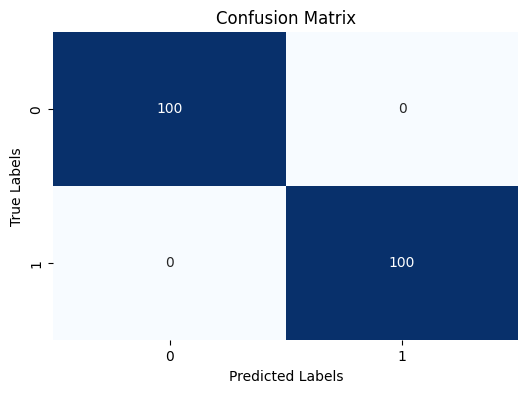

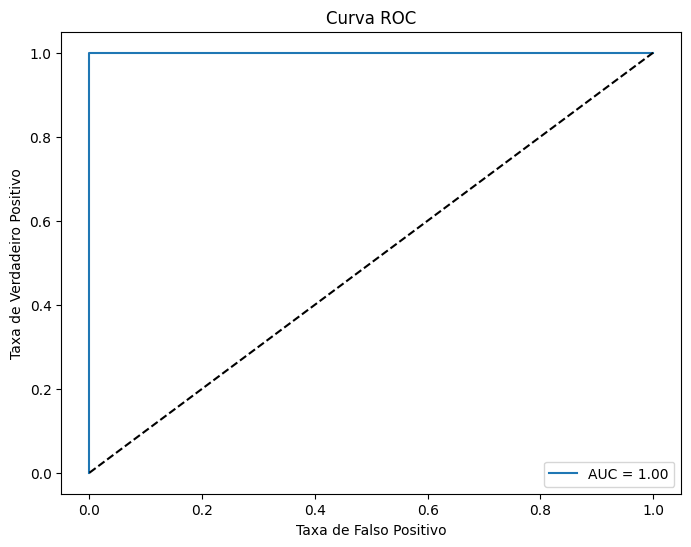

In [ ]:
# Confusion Matrix
classifier.confusion_matrix()

# ROC Curve
classifier.plot_roc_curve(X_test, y_test)